In [14]:
#Load Libraries
import tkinter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [15]:
#Load Dataset
cancer=pd.read_csv('./cancer.csv')
cancer.head()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
#Remove id Column
df=cancer.drop('id',axis=1)
df.head()

,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [5]:
#Show Key Statistics
df.describe()

,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [49]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(multi_class='multinomial',solver='newton-cg',
                                               random_state=100,max_iter=1000))])
pipeline.insert(0,pipe_logreg)

# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2'],
                   'clf__solver':['newton-cg', 'sag', 'saga' , 'lbfgs']}
modelpara.insert(0,param_gridlogreg)

In [50]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=100,
                   solver='newton-cg')

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}

 [[89  0]
 [ 3 45]]

               precision    recall  f1-score   support

   Outcome 0       0.97      1.00      0.98        89
   Outcome 1       1.00      0.94      0.97        48

    accuracy                           0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137

ROC Curve


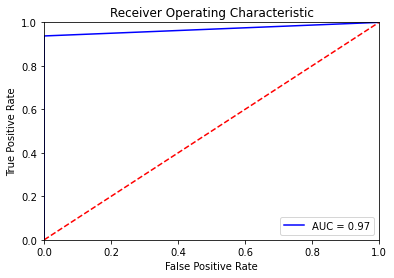

In [51]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)